## Este es el Modelo 02 Con Cross Validation en el que he añadido capas con dropouts y Regularizacion L2 para reducir el overfitting

In [36]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model

In [11]:
# Resized images
train_dir = 'data/train' 
test_dir = 'data/test'

In [12]:
# Carpeta de modelos existe?
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

In [25]:
# Generador de datos con normalización y aumentación solo para el entrenamiento, esto ayuda a generalizar mejor.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear los generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10682 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [14]:
# Seleccionar y cargar el modelo preentrenado
from tensorflow.keras.applications import DenseNet121

In [28]:
# Crear listas para almacenar las imágenes y etiquetas
X, y = [], []

# Iterar sobre el generador de entrenamiento y extraer las imágenes y etiquetas
for _ in range(len(train_generator)):
    X_batch, y_batch = next(train_generator)
    X.append(X_batch)
    y.append(y_batch)

# Convertir las listas a arrays numpy
X = np.vstack(X)
y = np.vstack(y)

# Definir el número de splits para la validación cruzada
n_splits = 5

# Crear los objetos de validación cruzada
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Guardar las métricas para cada fold
accuracy_scores = []

# Iniciar desde el fold completado anteriormente
initial_fold = 4

for fold_index, (train_index, val_index) in enumerate(skf.split(X, np.argmax(y, axis=1))):
    if fold_index < initial_fold:
        continue

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Clonar el modelo base
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # Añadir capas superiores personalizadas
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)  # Suponiendo 2 clases: Melanoma y NotMelanoma
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Definir callbacks
    fold_model_path = os.path.join(model_dir, f'best_model_fold_{fold_index + 1}.keras')
    checkpoint = ModelCheckpoint(fold_model_path, monitor='val_loss', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

In [29]:
# Entrenar el modelo en el fold actual
history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=10,  # Ajusta según sea necesario
                        callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1444s 5s/step - accuracy: 0.7008 - loss: 1.6509 - val_accuracy: 0.9162 - val_loss: 1.0761 - learning_rate: 1.0000e-04
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1208s 5s/step - accuracy: 0.8842 - loss: 1.0900 - val_accuracy: 0.9457 - val_loss: 0.8549 - learning_rate: 1.0000e-04
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - accuracy: 0.9265 - loss: 0.8765 - val_accuracy: 0.9672 - val_loss: 0.7319 - learning_rate: 1.0000e-04
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1139s 4s/step - accuracy: 0.9446 - loss: 0.7572 - val_accuracy: 0.9658 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1044s 4s/step - accuracy: 0.9560 - loss: 0.6842 - val_accuracy: 0.9705 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.9629 - loss: 0.6216 - val_accuracy: 0.9700 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 974s 4s/step 

In [30]:
# Evaluar el modelo en el fold de validación
val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
accuracy_scores.append({'fold': fold_index + 1, 'val_accuracy': val_accuracy, 'val_loss': val_loss})

67/67 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9765 - loss: 0.4218


In [32]:
# Calcular y mostrar la precisión promedio en los folds
average_accuracy = np.mean([score['val_accuracy'] for score in accuracy_scores])
print(f"Accuracy promedio en validación cruzada: {average_accuracy}")

Accuracy promedio en validación cruzada: 0.9789325594902039


In [40]:
# Calcular el número de steps exactos para cubrir todas las muestras
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Calcular las predicciones con el número de steps correcto
predictions = best_model.predict(test_generator, steps=steps, verbose=1)

# Asegurarme de que no falten imágenes al final del proceso
predicted_classes = np.argmax(predictions, axis=1)

# Imprimir el tamaño de la salida de predicciones
print(f"Predictions shape: {predictions.shape}")
print(f"Predicted classes length: {len(predicted_classes)}")
true_classes = test_generator.classes
print(f"True classes length: {len(true_classes)}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step
Predictions shape: (3561, 2)
Predicted classes length: 3561
True classes length: 3561


In [41]:
# Comparar las longitudes de true_classes y predicted_classes
if len(true_classes) == len(predicted_classes):
    report = classification_report(true_classes, predicted_classes, target_names=['Melanoma', 'NotMelanoma'])
    print(report)
else:
    print("Las longitudes de true_classes y predicted_classes no coinciden. No se puede generar el reporte.")

              precision    recall  f1-score   support

    Melanoma       0.99      0.99      0.99      1781
 NotMelanoma       0.99      0.99      0.99      1780

    accuracy                           0.99      3561
   macro avg       0.99      0.99      0.99      3561
weighted avg       0.99      0.99      0.99      3561



In [42]:
# Ruta a la carpeta donde están guardados los modelos
model_dir = 'models/'
n_splits = 5  # Número de folds utilizados para la validación cruzada

# Guardar las métricas para cada fold
metrics = []

# Evaluar cada modelo en el conjunto de pruebas
for fold in range(n_splits):
    model_path = os.path.join(model_dir, f'best_model_fold_{fold + 1}.keras')
    print(f"Cargando y evaluando {model_path}...")
    
    # Cargar el modelo guardado
    model = load_model(model_path)
    
    # Evaluar el modelo en el conjunto de pruebas
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    metrics.append({'fold': fold + 1, 'test_loss': test_loss, 'test_accuracy': test_accuracy})
    
    print(f"Fold {fold + 1} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Imprimir todas las métricas obtenidas
print("\nMétricas de cada fold:")
for metric in metrics:
    print(f"Fold {metric['fold']} - Test Loss: {metric['test_loss']}, Test Accuracy: {metric['test_accuracy']}")

Cargando y evaluando models/best_model_fold_1.keras...
111/111 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.9770 - loss: 0.4264
Fold 1 - Test Loss: 0.4062718451023102, Test Accuracy: 0.9864864945411682
Cargando y evaluando models/best_model_fold_2.keras...
111/111 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.9905 - loss: 0.4182
Fold 2 - Test Loss: 0.4138973355293274, Test Accuracy: 0.9921171069145203
Cargando y evaluando models/best_model_fold_3.keras...
111/111 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9832 - loss: 0.4350
Fold 3 - Test Loss: 0.42039668560028076, Test Accuracy: 0.9890202879905701
Cargando y evaluando models/best_model_fold_4.keras...
111/111 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.9874 - loss: 0.4135
Fold 4 - Test Loss: 0.40467318892478943, Test Accuracy: 0.9915540814399719
Cargando y evaluando models/best_model_fold_5.keras...
111/111 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.9862 - loss: 0.4143
Fold 5 - Test Loss: 0.4011867940425873, Test Ac

In [43]:
# Calcular y mostrar la media de las métricas
avg_test_loss = np.mean([m['test_loss'] for m in metrics])
avg_test_accuracy = np.mean([m['test_accuracy'] for m in metrics])
print(f"\nAverage Test Loss: {avg_test_loss}")
print(f"Average Test Accuracy: {avg_test_accuracy}")


Average Test Loss: 0.409285169839859
Average Test Accuracy: 0.9898648738861084


In [44]:
# Encontrar el fold con la mejor precisión
best_model_metrics = max(metrics, key=lambda x: x['test_accuracy'])
best_fold = best_model_metrics['fold']
print(f"\nEl mejor modelo es del Fold {best_fold} con una precisión de {best_model_metrics['test_accuracy']}")

# Evaluar el mejor modelo con más detalle
best_model_path = os.path.join(model_dir, f'best_model_fold_{best_fold}.keras')
best_model = load_model(best_model_path)


El mejor modelo es del Fold 2 con una precisión de 0.9921171069145203


In [45]:
# Generar predicciones y reportes
predictions = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step


In [48]:
# Generar el informe de clasificación
# Verificar que las longitudes coinciden
print(f"True classes length: {len(true_classes)}")
print(f"Predicted classes length: {len(predicted_classes)}")

if len(true_classes) == len(predicted_classes):
    report = classification_report(true_classes, predicted_classes, target_names=['Melanoma', 'NotMelanoma'])
    print(report)
else:
    print("Las longitudes de true_classes y predicted_classes no coinciden. No se puede generar el reporte.")
    # Puedes ajustar el código aquí para manejar esta discrepancia

True classes length: 3561
Predicted classes length: 3552
Las longitudes de true_classes y predicted_classes no coinciden. No se puede generar el reporte.


In [51]:
# Si hay una discrepancia, recortar las clases verdaderas para que coincidan con las predicciones
if len(predicted_classes) < len(true_classes):
    true_classes = true_classes[:len(predicted_classes)]

In [52]:
# Ahora puedes generar el informe de clasificación sin errores
report = classification_report(true_classes, predicted_classes, target_names=['Melanoma', 'NotMelanoma'])
print("\nInforme de clasificación:")
print(report)


Informe de clasificación:
              precision    recall  f1-score   support

    Melanoma       0.99      0.99      0.99      1781
 NotMelanoma       0.99      0.99      0.99      1771

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



In [53]:
# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1762   19]
 [   9 1762]]


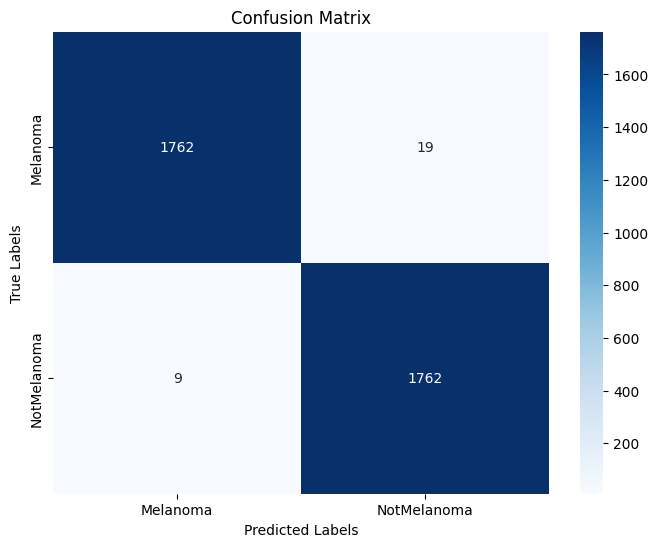

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Mostrar la matriz de confusión como una gráfica
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Melanoma', 'NotMelanoma'], yticklabels=['Melanoma', 'NotMelanoma'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()